# 5장 컴퓨터 비전을 위한 딥러닝_2

[케라스 창시자에게 배우는 딥러닝] 책을 기반으로 제가 정리하고 요약한 내용입니다.  
지난 5장 앞부분에 이어서 5.3절 사전 훈련된 컨브넷 사용하기 부터 시작합니다. 이번 역시 구글 코랩에서 진행합니다.

## 5.3 사전 훈련된 컨브넷 사용하기

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 사전 훈련된 네트워크를 사용하는 것입니다.  
**사전 훈련된 네트워크(pretrained network)** 는 일반적으로 대규모 이미지 분류 문제를 위해 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다.

새로운 문제가 원래 작업과 완전히 다른 클래스에 대한 것이더라도 이런 특성은 많은 컴퓨터 비전 문제에 유용합니다. ImageNet 데이터셋(대부분 동물이나 생활용품으로 이루어진)에 네트워크를 훈련하여 가구 아이템을 식별하는 용도로 사용할  수 있습니다.

여기에서는 (1,400만 개의 레이블된 이미지와 1,000개의 클래스로 이루어진) ImageNet 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다.

사용할 수 있는 모델은 VGG, ResNet, Inception... 등이 있는데 이번엔 VGG16 모델을 사용합니다.

사전 훈련된 네트워크를 사용하는 2가지 방법입니다.
1. **특성 추출(feature extraction)**
2. **미세 조정(fine tuning)**

### 5.3.1 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

컨브넷은 이미지 분류를 위해 두 부분으로  구성됩니다.
* 연속된 합성곱과 풀링 층으로 시작
* 완전 연결 분류기로 끝

컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련합니다.

왜 합성곱 층만 재사용하고 완전 연귤 분류기는 재사용하지 않을까요? 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문입니다.
* 컨브넷의 특성 맵은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록한 맵입니다. 주어진 컴퓨터 비전 문제에 상관없이 유용하게 사용할 수 있습니다.
* But 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만 담고 있습니다.
* 완전 연결 층에서 찾은 표현은 더 이상 입력 이미지에 있는 객체의 위치 정보를 가지고 있지 않습니다.

특정 합성곱 층에서 추출한 표현의 일반성 및 재사용성 수준은 모델에 있는 층의 깊이에 따라 달려있습니다.
* 모델 하위 층 : 에지, 색깔, 질감 등 지역적이고 매우 일반적인 특성 맵
* 모델 상위 층 : 강아지 눈, 고양이 귀와 같은 좀 더 추상적인 개념

새로운 데이터셋과 훈련된 데이터셋이 많이 다르다면 전체 합성곱 기반 층이 아닌 모델의 하위 층 몇 개만 특성 추출에 사용하는 것이 좋습니다.

ImageNet 클래스에서는 강아지와 고양이가 있기 때문에 완전 연결 층 정보를 재사용해도 좋지만 일반적인 케이스를 위해 여기서는 사용하지 않습니다. ImageNet 데이터셋에서 훈련된 VCG16 네트워크에서 유용한 특성을 추출합니다. 그 후 특성으로 분류기를 훈련합니다.

VGG16 모델은 케라스 패키지로 존재하며 ```keras.applications``` 모듈에서 import 할 수 있습니다. 이 모듈에서 사용가능한 이미지 분류 모델은 다음과 같습니다.
* Xception
* Inception V3
* ResNet50
* VGG16
* VGG19
* MobileNet

VGG 16 모델을 만들어 봅시다.

In [0]:
# 코드 5-16 VGG16 합성곱 기반 층 만들기
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

* weights: 모델을 초기화할 가중치 체크포인트를 지정합니다.
* include_top: 네트워크의 최상위 완전 연결 분류기를 포함할지 안 할지를 지정합니다. 기본값은 ImageNet의 클래스 1,000개에 대응되는 완전 연결 분류기를 포함합니다. 별도의 (강아지와 고양이 2개 클래스를 구분하는) 완전 연결 층을 추가하려고 하므로 이를 포함하지 않습니다.
* input_shape: 네트워크에 주입할 이미지 텐서의 크기입니다. 이 매개변수는 선택 사항입니다. 이 값을 지정하지 않으면 네트워크가 어떤 크기의 입력도 처리할 수 있습니다.

In [2]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

최종 특성 맵의 크기는 (4, 4, 512)입니다. 이 특성 위에 완전 연결 층을 놓을 것입니다.

이 지점에서 두 가지 방식이 가능합니다.
1. 새로운 데이터셋에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용합니다. 이 방식에서는 합성곱 기반 층을 한 번만 실행하기 때문에 빠르고 비용이 적게 듭니다. 하지만 데이터 증식을 사용할 수 없습니다.

2. 준비한 모델(conv_base)에 Dense 층을 쌓아 확장합니다. 그리고 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행합니다. 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반 층을 통과하므로 데이터 증식을 사용할 수 있습니다. 하지만 첫 번째 방식보다 훨씬 비용이 많이 듭니다.

두 가지 방식을 모두 다루어 보겠습니다.

**데이터 증식을 사용하지 않는 빠른 특성 추출**

ImageDatagenerator를 사용하여 이미지와 레이블을 넘파이 배열로 추출합니다. conv_base 모델의 predict 메서드를 호출하여 이 이미지에서 특성을 추출합니다.

In [4]:
!ls

cats_and_dogs_small	  kaggle.json		test1	   train.zip
cats_and_dogs_small_1.h5  sample_data		test1.zip
cats_and_dogs_small_2.h5  sampleSubmission.csv	train


In [5]:
# 코드 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count))
  generator = datagen.flow_from_directory(directory,
                                          target_size=(150, 150),
                                          batch_size=batch_size,
                                          class_mode='binary')
  i = 0
  for inputs_batch, labels_batch in generator:
    features_batch = conv_base.predict(inputs_batch)
    features[i * batch_size : (i + 1) * batch_size] = features_batch
    labels[i * batch_size : (i + 1) * batch_size] = labels_batch
    i += 1
    if i * batch_size >= sample_count:
      break  # 제네레이터는 루프 안에서 무한하게 데이터를 만들어 내므로 모든 이미지를 한번씩 처리하고 나면 중지합니다.
  return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다.

In [0]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

이제 완전 연결 분류기를 정의하고(규제를 위해 드롭아웃 사용) 저장된 데이터와 레이블을 사용하여 훈련합니다.

In [7]:
# 코드 5-18 완전 연결 분류기를 정의하고 훈련하기
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

W0827 06:58:57.292380 139719457318784 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0827 06:58:57.420289 139719457318784 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 06:58:57.431110 139719457318784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 614us/step - loss: 0.6047 - acc: 0.6690 - val_loss: 0.4638 - val_acc: 0.8200
Epoch 2/30
2000/2000 [==============================] - 1s 392us/step - loss: 0.4334 - acc: 0.8025 - val_loss: 0.3768 - val_acc: 0.8500
Epoch 3/30
2000/2000 [==============================] - 1s 387us/step - loss: 0.3637 - acc: 0.8490 - val_loss: 0.3356 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 1s 395us/step - loss: 0.3173 - acc: 0.8685 - val_loss: 0.3095 - val_acc: 0.8810
Epoch 5/30
2000/2000 [==============================] - 1s 383us/step - loss: 0.2909 - acc: 0.8825 - val_loss: 0.2941 - val_acc: 0.8800
Epoch 6/30
2000/2000 [==============================] - 1s 400us/step - loss: 0.2719 - acc: 0.8950 - val_loss: 0.2800 - val_acc: 0.8900
Epoch 7/30
2000/2000 [==============================] - 1s 387us/step - loss: 0.2483 - acc: 0.9090 - val_loss: 0.2761 - val_acc: 0.8830


이번엔 2개의 Dense 층만 처리하면 되기 때문에 훈련이 매우 빠릅니다.

훈련 손실과 정확도 곡선을 그려봅니다.

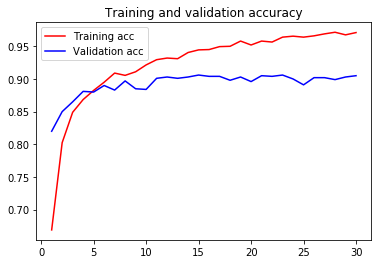

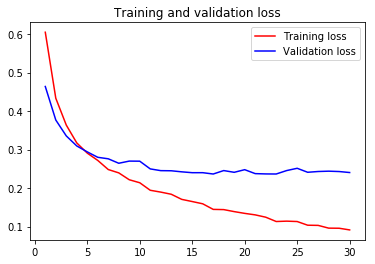

In [8]:
# 코드 5-19 결과 그래프 그리기
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 이전에 처음부터 훈련시킨 작은 모델보다 훨씬 좋습니다. 하지만 이 그래프도 많은 드롭아웃을 사용했음에도 오버피팅이 생깁니다. 작은 이미지 데이터셋에서는 과대적합을 막기 위해 필수적인 데이터 증식을 사용하지 않았기 때문입니다.

**데이터 증식을 사용한 특성 추출**

이전 방법보다는 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식을 사용할 수 있습니다. 무조건 GPU에서 이방법을 쓰세요!  
conv_base 모델을 확장하고 입력 데이터를 사용하여 엔드-투-엔드로 실행합니다.

모델은 층과 동일하게 작동하므로 층을 추가하듯이 Sequential 모델에 다른 모델을 추가할 수 있습니다.  
여기선 **```conv_base```** 모델을 추가했습니다.

In [0]:
# 코드 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가하기
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16의 합성곱 기반 층은 14,714,688개의 매우 많은 파라미터를 가지고 있습니다. 그 위에 추가한 분류기는 200만 개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 동결하는 것이 아주 중요합니다. 하나 이상의 층을 **동결(freezing)** 한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 뜻입니다. 동결을 하지 않으면 사전에 학습된 표현을 크게 훼손하게 됩니다.  
케라스에서는 ```trainable``` 속성을 False로 설정하여 네트워크를 동결할 수 있습니다.

In [11]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base.trainable = False

print('conv_base를 동결한 후 훈련되는 가중치의 수:', len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


이렇게 설정하면 추가한 2개의 Dense 층 가중치만 훈련될 것입니다. 층마다 2개씩(가중치 행렬과 편향 벡터) 총 4개의 텐서가 훈련됩니다.

이제 데이터 증식을 사용하여 모델 훈련을 합니다.

In [12]:
# 코드 5-21 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

# 검증 데이터는 증식되어서는 안 됩니다!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(150, 150), # 모든 이미지의 크기를 150 × 150로 변경합니다
                                                    batch_size=20,
                                                    class_mode='binary')    # binary_crossentropy 손실을 사용하므로 이진 레이블이 필요합니다

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=30,
                              validation_data=validation_generator,
                              validation_steps=50,
                              verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 25s - loss: 0.5552 - acc: 0.7215 - val_loss: 0.4202 - val_acc: 0.8360
Epoch 2/30
 - 24s - loss: 0.4117 - acc: 0.8315 - val_loss: 0.3468 - val_acc: 0.8550
Epoch 3/30
 - 23s - loss: 0.3473 - acc: 0.8600 - val_loss: 0.3088 - val_acc: 0.8710
Epoch 4/30
 - 23s - loss: 0.3277 - acc: 0.8665 - val_loss: 0.3020 - val_acc: 0.8710
Epoch 5/30
 - 23s - loss: 0.3111 - acc: 0.8710 - val_loss: 0.2715 - val_acc: 0.8920
Epoch 6/30
 - 23s - loss: 0.2891 - acc: 0.8865 - val_loss: 0.2593 - val_acc: 0.8970
Epoch 7/30
 - 23s - loss: 0.2745 - acc: 0.8900 - val_loss: 0.2649 - val_acc: 0.8920
Epoch 8/30
 - 24s - loss: 0.2660 - acc: 0.8905 - val_loss: 0.2484 - val_acc: 0.8970
Epoch 9/30
 - 24s - loss: 0.2570 - acc: 0.8945 - val_loss: 0.2418 - val_acc: 0.9030
Epoch 10/30
 - 23s - loss: 0.2566 - acc: 0.8890 - val_loss: 0.2443 - val_acc: 0.8990
Epoch 11/30
 - 24s - loss: 0.2461 - acc: 0.9155 - val_loss: 0.2436 - val_ac

이제 모델을 저장하고 그래프를 그려봅니다.

In [0]:
model.save('cats_and_dogs_small_3.h5')

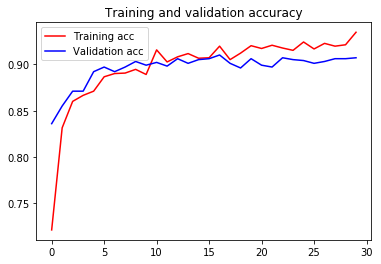

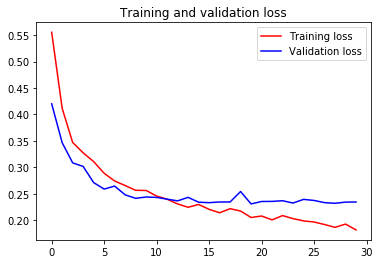

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

검증 정확도는 이전과 비슷하지만 오버피팅이 줄었습니다.

### 5.3.2 미세 조정

모델을 재사용하는 데 널리 사용되는 또 하나의 기법은 특성 추출을 보완하는 **미세 조정(fine tuning)** 입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇 개를 동결에서 해제하고 모델에 새로 추가한 층(여기서는 완전 연결 분류기)과 함께 훈련하는 것입니다.

여기서 주의할 점은 분류기가 미리 훈련된 이후에 합성곱 기반의 상위 층을 미세 조정 하는 것입니다. 미리 훈련되지 않으면 사전에 학습한 표현들이 망가집니다.  
네트워크를 미세 조정하는 단계는 다음과 같습니다.
1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다.
2. 기반 네트워크를 동결합니다.
3. 새로 추가한 네트워크를 훈련합니다.
4. 기반 네트워크에서 일부 층의 동결을 해제합니다.
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다.

처음 세 단계는 특성 추출을 할 때 이미 완료했으므로 네 번째 단계부터 진행합니다. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

In [15]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

마지막 3개의 합성곱 층을 미세 조정하겠습니다. 즉 block4_pool까지 모든 층은 동결되고 block5_conv1, block5_conv2, block5_conv3 층은 학습 대상이 됩니다.

더 많은 층을 미세 조정하지 않는 이유는 무엇일까요?
* 합성곱 기반 층에 있는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩
* 반면 상위 층은 좀 더 특화된 특성을 인코딩 -> 새로운 문제에는 구체적인 특성이 필요 -> 상위층만 미세 조정하는 것이 유리합니다.
* 훈련해야 할 파라미터가 많을수록 오버피팅의 위험이 커집니다. 합성곱 기반 층은 1,500 만 개의 파라미터를 가지고 있습니다. 작은 데이터셋으로 전부 훈련하려고 하면 매우 위험합니다.

이제 미세 조정을 설정합니다.

In [0]:
# 코드 5-22 특정 층까지 모든 층 동결하기
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

이제 네트워크의 미세 조정을 시작합니다. 학습률을 낮춘 RMSprop 옵티마이저를 사용합니다. 학습률이 높으면 학습된 표현에 나쁜 영향을 끼칠 수 있고 학습된 표현을 조금씩 수정하기 위해서 입니다.

In [18]:
# 코드 5-23 모델 미세 조정하기

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=100,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 26s 265ms/step - loss: 0.1986 - acc: 0.9210 - val_loss: 0.2414 - val_acc: 0.9030
Epoch 2/100
100/100 [==============================] - 25s 248ms/step - loss: 0.1548 - acc: 0.9355 - val_loss: 0.3090 - val_acc: 0.8760
Epoch 3/100
100/100 [==============================] - 25s 247ms/step - loss: 0.1417 - acc: 0.9475 - val_loss: 0.2042 - val_acc: 0.9230
Epoch 4/100
100/100 [==============================] - 24s 244ms/step - loss: 0.1211 - acc: 0.9490 - val_loss: 0.2089 - val_acc: 0.9180
Epoch 5/100
100/100 [==============================] - 25s 247ms/step - loss: 0.1048 - acc: 0.9600 - val_loss: 0.2228 - val_acc: 0.9180
Epoch 6/100
100/100 [==============================] - 25s 249ms/step - loss: 0.0895 - acc: 0.9665 - val_loss: 0.2224 - val_acc: 0.9210
Epoch 7/100
100/100 [==============================] - 25s 247ms/step - loss: 0.0813 - acc: 0.9710 - val_loss: 0.2168 - val_acc: 0.9150
Epoch 8/100
100/100 [===========================

In [0]:
model.save('cats_and_dogs_small_4.h5')

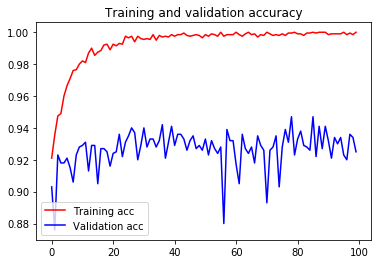

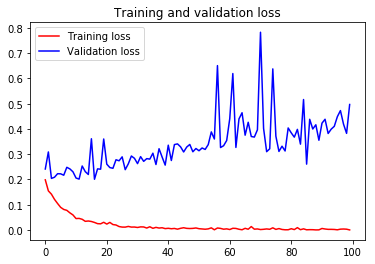

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보이기 때문에 그래프를 보기 쉽게 하기 위해 **지수 이동 평균(exponential moving average)** 으로 정확도와 손실 값을 부드럽게 표현할 수 있습니다.  
다음은 지수 이동 평균을 구하기 위한 간단한 함수입니다.

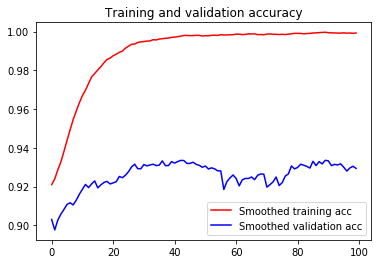

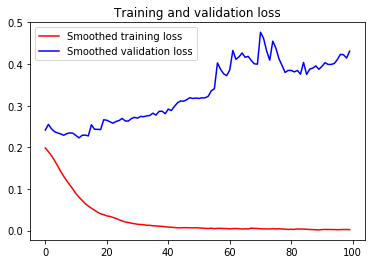

In [21]:
# 코드 5-24 부드러운 그래프 그리기
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'r', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'r', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

정확도는 조금 올랐지만 손실 곡선은 실제 어떤 향상을 얻지 못했습니다. 손실이 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요?

그래프는 개별적인 손실 값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임계 값을 넘었는지에 대한 결과이기 때문입니다. 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있습니다.  
(정확도를 직접 최적화할 수 없고 크로스엔트로피 같은 대리 손실 함수를 사용하기 때문에 이런 현상이 발생할 수 있습니다.)

마지막으로 테스트 데이터에서 모델을 평가하겠습니다.

In [22]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150, 150),
                                                  batch_size=20,
                                                  class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9319999957084656


약 93%의 테스트 정확도를 얻었습니다.

### 5.3.3 정리

* 컨브넷은 컴퓨터 비전 작업에 가장 뛰어난 머신 러닝 모델입니다. 아주 작은 데이터셋에서도 처음부터 훈련해서 괜찮은 성능을 낼 수 있습니다.
* 작은 데이터셋에서는 오버피팅이 큰 문제입니다. 데이터 증식은 이미지 데이터를 다룰 때 오버피팅을 막을 수 있는 강력한 방법입니다.
* 특성 추출 방식으로 새로운 데이터셋에 기존 컨브넷을 쉽게 재사용할 수 있습니다. 작은 이미지 데이터셋으로 작업할 때 효과적인 기법입니다.
* 특성 추출을 보완하기 위해 미세 조정을 사용할 수 있습니다. 미세 조정은 기존 모델에서 사전에 학습한 표현의 일부를 새로운 문제에 적응시킵니다. 이 기법은 조금 더 성능을 끌어올립니다.

지금까지 이미지 분류 문제에서 특히 작은 데이터셋을 다루기 위한 좋은 도구들을 배웠습니다.